# MDI+: Example Usages

In [291]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [292]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [293]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [294]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [295]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.36153922459269183

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [296]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.492901  0.754909  0.188679  0.078771  0.070798  0.061140  0.166825   
1    0.558364  0.693242  0.123109  0.072985  0.072128  0.057468  0.197374   
2    0.554491  0.862104  0.129659  0.060557  0.053545  0.059279  0.115065   
3    0.559630  1.101681  0.108913  0.064710  0.051627  0.051499  0.149503   
4    0.448522  0.622109  0.111504  0.065669  0.094904  0.101208  0.259028   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.645876  0.627457  0.128792  0.078334  0.150669  0.058992  0.200149   
130  0.467203  0.615661  0.106387  0.085278  0.084828  0.157217  0.197231   
131  0.456709  1.103035  0.113017  0.064620  0.070451  0.042618  0.156995   
132  0.440427  0.785996  0.163472  0.097232  0.059953  0.102608  0.135983   
133  0.555986  0.703879  0.138478  0.073279  0.107

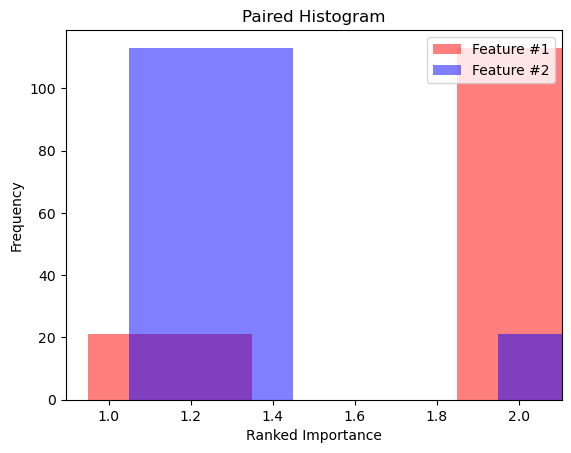

In [297]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [298]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.367065  0.551174  0.174281  0.072101  0.062353  0.057159  0.152092   
1    0.537364  0.653855  0.106859  0.071054  0.070166  0.055975  0.180863   
2    0.529237  0.720000  0.109712  0.058669  0.050777  0.058030  0.102724   
3    0.447723  1.077215  0.095042  0.053882  0.047162  0.050443  0.136759   
4    0.318608  0.410197  0.098078  0.059598  0.080806  0.094618  0.241092   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.479824  0.494950  0.104098  0.075739  0.148691  0.056233  0.175729   
130  0.420175  0.469492  0.086205  0.077942  0.083203  0.153574  0.192270   
131  0.327169  1.081896  0.098757  0.052750  0.064203  0.040643  0.131323   
132  0.375815  0.617672  0.139750  0.082301  0.056783  0.097471  0.123307   
133  0.529976  0.642240  0.119891  0.071148  0.105

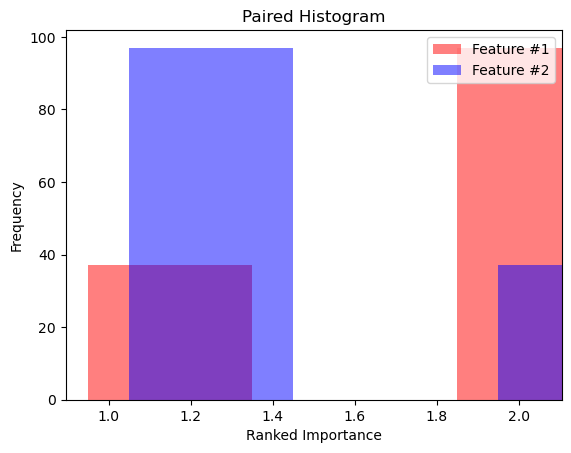

In [299]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()